<center><a href="https://www.featuretools.com/"><img src="img/featuretools-logo.png" width="400" height="200" /></a></center>

<h2> A Featuretools Baseline </h2>
<p>The following tutorial illustrates a featuretools baseline model for the NYC Taxi Trip Duration competition on Kaggle. This notebook follows the structure of the previous worksheet, but uses deep feature synthesis to create the model.</p>

<h2>Step 1: Download raw data </h2>
<p>As always, if you have not yet downloaded the data it can be found at the <a href="https://www.kaggle.com/c/nyc-taxi-trip-duration/data">Kaggle website</a>. After installing featuretools following <a href = "https://docs.featuretools.com/">the instructions in the documentation</a> you can run the following.
</p>


In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
import taxi_utils

import warnings
warnings.simplefilter('ignore')

ft.__version__

'1.4.0'

In [2]:
TRAIN_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"

data_train, data_test = taxi_utils.read_data(TRAIN_DIR, TEST_DIR)

data_train.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,False,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,False,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,False,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,False,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,False,435


<h2>Step 2: Prepare the Data </h2>
<p>Let's create another column to define test and train datasets.</p>

In [3]:
data_train['test_data'] = False
data_test['test_data'] = True

<p>We can now combine the data. </p>

In [4]:
data = pd.concat([data_train, data_test], sort=True)

<h2>Step 3: Create baseline features using DFS </h2>
<p>Instead of manually creating features, such as month of <b>pickup_datetime</b>, we can let featuretools come up with them. </p>

<p>Within featuretools there is a standard format for representing data that is used to set up predictions and build features. A <b>EntitySet</b> stores information about dataframes (database table), columns in the dataframes, relationships, and the data itself. </p>

<p> First, we create the EntitySet.</p>

In [5]:
es = ft.EntitySet("taxi")

We can then use the `add_dataframe` method to add a dataframe called <i>trips</i>. We want to track the `id`, the `time_index` and specify other column types we care about in this table.

<p>As a note: Featuretools will try to interpret the types of columns. We can override this interpretation by specifying the types. In this case, I wanted <b>passenger_count</b> to be a type of Ordinal, and <b>vendor_id</b> to be of type Categorical.</p>

In [6]:
from woodwork.logical_types import Ordinal
trip_logical_types = {
    'passenger_count': Ordinal(order=list(range(0, 10))), 
    'vendor_id': 'Categorical',
}

es.add_dataframe(dataframe_name="trips",
                 dataframe=data,
                 index="id",
                 time_index='pickup_datetime',
                 logical_types=trip_logical_types)

Entityset: taxi
  DataFrames:
    trips [Rows: 2050266, Columns: 11]
  Relationships:
    No relationships

In [7]:
es['trips']

,dropoff_latitude,dropoff_longitude,id,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,test_data,trip_duration,vendor_id
id0190469,40.829182,-73.938828,id0190469,5,2016-01-01 00:00:17,40.719158,-73.981743,False,False,849.0,2
id0621643,40.769379,-73.969330,id0621643,2,2016-01-01 00:00:22,40.716881,-73.981850,False,True,NaN,2
id1384355,40.891788,-73.854263,id1384355,1,2016-01-01 00:00:28,40.733562,-73.976501,False,True,NaN,1
id1665586,40.717491,-73.958038,id1665586,1,2016-01-01 00:00:53,40.747166,-73.985085,False,False,1294.0,1
id1210365,40.815170,-73.947479,id1210365,5,2016-01-01 00:01:01,40.801041,-73.965279,False,False,408.0,2
...,...,...,...,...,...,...,...,...,...,...,...
id3719493,40.675968,-73.973160,id3719493,1,2016-06-30 23:59:39,40.791576,-73.978416,False,False,2609.0,2
id2150126,40.730469,-73.986427,id2150126,1,2016-06-30 23:59:41,40.771900,-73.956070,False,True,NaN,2
id1217141,40.729523,-73.986160,id1217141,1,2016-06-30 23:59:47,40.737583,-73.997437,False,True,NaN,1
id3505355,40.655403,-73.959808,id3505355,1,2016-06-30 23:59:53,40.679993,-73.964203,False,True,NaN,1


<p>We can also normalize some of the columns to create new dataframes. So a <i>vendors</i> dataframe is created based on the unique values in the <i>vendor_id</i> column in <i>trips</i>.</p>

In [8]:
es.normalize_dataframe(base_dataframe_name="trips",
                       new_dataframe_name="vendors",
                       index="vendor_id")

es.normalize_dataframe(base_dataframe_name="trips",
                       new_dataframe_name="passenger_cnt",
                       index="passenger_count")

Entityset: taxi
  DataFrames:
    trips [Rows: 2050266, Columns: 11]
    vendors [Rows: 2, Columns: 2]
    passenger_cnt [Rows: 8, Columns: 2]
  Relationships:
    trips.vendor_id -> vendors.vendor_id
    trips.passenger_count -> passenger_cnt.passenger_count

<p>We can specify the time for each instance of the target dataframe to calculate features. The timestamp represents the last time data can be used for calculating features by DFS. This is specified using a dataframe of cutoff times. Below we can see that the cutoff time for each trip is the pickup time.</p>

In [9]:
cutoff_time = es['trips'][['id', 'pickup_datetime']]

In [10]:
es.add_interesting_values()

## Visualize EntitySet

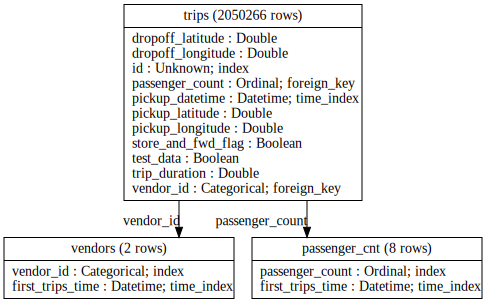

In [11]:
es.plot()

<p>Given this dataset, we would have about 2 million unique cutoff times. This is a good use case to use the approximate features parameter of DFS. In a large dataset, direct features that are aggregations on the prediction dataframe may not change much from cutoff time to cutoff time. Calculating the aggregation features at specific times every hour and using it for all cutoff times within the hour would save time and perhaps not lose much information. The approximate parameter in DFS lets you specify a window size to use when approximating these direct aggregation features.</p>

<p>We now create features using DFS.</p>

In [12]:
trans_primitives = ['Minute', 'Hour', 'Day', 'Week', 'Month', 'Weekday', 'Is_weekend']

feature_matrix, features = ft.dfs(entityset=es,
                                  target_dataframe_name="trips",
                                  trans_primitives=trans_primitives,
                                  drop_contains=['trips.test_data'],
                                  verbose=True,
                                  cutoff_time=cutoff_time,
                                  approximate='36d')

Built 96 features
Elapsed: 02:08 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████


<p>Here are the features created. Notice how some of the features match the manually created features in the previous notebook.</p>

In [13]:
print(len(features))

96


In [14]:
features[:25]

[<Feature: dropoff_latitude>,
 <Feature: dropoff_longitude>,
 <Feature: passenger_count>,
 <Feature: pickup_latitude>,
 <Feature: pickup_longitude>,
 <Feature: store_and_fwd_flag>,
 <Feature: test_data>,
 <Feature: trip_duration>,
 <Feature: vendor_id>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: vendors.COUNT(trips)>,
 <Feature: vendors.MAX(trips.dropoff_latitude)>,
 <Feature: vendors.MAX(trips.dropoff_longitude)>,
 <Feature: vendors.MAX(trips.pickup_latitude)>,
 <Feature: vendors.MAX(trips.pickup_longitude)>,
 <Feature: vendors.MAX(trips.trip_duration)>,
 <Feature: vendors.MEAN(trips.dropoff_latitude)>,
 <Feature: vendors.MEAN(trips.dropoff_longitude)>,
 <Feature: vendors.MEAN(trips.pickup_latitude)>]

<h2>Step 3: Build the Model </h2>

<p>We need to retrieve our labels for the train dataset, so we should merge our current feature matrix with the original dataset. </p>
<p>We also get the log of the trip duration so that a more linear relationship can be found.</p>

In [15]:
# convert integer columns with pd.NA values to doubles to prevent XGB error
for col in feature_matrix.columns:
    if feature_matrix[col].dtype == 'Int64':
        feature_matrix[col] = feature_matrix[col].astype('float64')

In [16]:
# separates the whole feature matrix into train data feature matrix, train data labels, and test data feature matrix 
X_train, labels, X_test = taxi_utils.get_train_test_fm(feature_matrix)
labels = np.log(labels.values + 1)

In [17]:
model = taxi_utils.train_xgb(X_train, labels)

[0]	train-rmse:5.00486	valid-rmse:5.00461
[10]	train-rmse:1.01991	valid-rmse:1.02032
[20]	train-rmse:0.61401	valid-rmse:0.61639
[30]	train-rmse:0.52868	valid-rmse:0.53225
[40]	train-rmse:0.49999	valid-rmse:0.50487
[50]	train-rmse:0.48259	valid-rmse:0.48853
[59]	train-rmse:0.46825	valid-rmse:0.47509
Modeling RMSE 0.47509


## Step 4: Build the model automatically
<p align="center">
<img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>






Up to now, we have been training a single xgboost model. However, there are many different model types that could be useful. Common ones include Catboost, LightGBM, and Random Forest Models. Using [EvalML](https://evalml.alteryx.com/en/stable/), an open source autoML library created by Alteryx, we can automatically build and tune multiple models, as well as compare the results 

In [ ]:
import evalml
from evalml import AutoMLSearch

automl = AutoMLSearch(X_train=X_train,
                      y_train=labels,
                      problem_type="regression",
                      objective="root mean squared error")
automl.search()

In [19]:
pipeline = automl.best_pipeline
pipeline.fit(X_train, labels)

pipeline = RegressionPipeline(component_graph={'Imputer': ['Imputer', 'X', 'y'], 'One Hot Encoder': ['One Hot Encoder', 'Imputer.x', 'y'], 'XGBoost Regressor': ['XGBoost Regressor', 'One Hot Encoder.x', 'y']}, parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'One Hot Encoder':{'top_n': 10, 'features_to_encode': None, 'categories': None, 'drop': 'if_binary', 'handle_unknown': 'ignore', 'handle_missing': 'error'}, 'XGBoost Regressor':{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'n_jobs': -1}}, random_seed=0)

Notice that with evalML, we were able to create a model with a better RMSE than just building a simple xgboost model. In the last part of the demo, where we incorporate custom features, we will exclusively use evalML for model building

<h2>Step 4: Make a Submission </h2>

In [20]:
submission = pipeline.predict(X_test)
submission.head(5)

id
id0621643    7.145653
id1384355    7.597363
id2568735    7.089373
id3700764    6.964109
id3008929    5.869703
dtype: float64

In [21]:
submission.to_csv('trip_duration_ft_simple.csv', index=True, index_label='id')

<h2>Additional Analysis</h2>
<p>Let's look at how important each feature was for the model.</p>

In [22]:
feature_names = X_train.columns.values
ft_importances = taxi_utils.feature_importances(model, feature_names)
ft_importances

,feature_name,importance
4,pickup_longitude,2808.0
0,dropoff_latitude,2643.0
3,pickup_latitude,1968.0
1,dropoff_longitude,1812.0
7,DAY(pickup_datetime),702.0
...,...,...
43,vendors.SUM(trips.dropoff_longitude),0.0
30,vendors.MODE(trips.passenger_count),0.0
29,vendors.MIN(trips.trip_duration),0.0
19,vendors.MAX(trips.trip_duration),0.0


<p align="center">
<img width=50% src="https://alteryx-open-source-images.s3.amazonaws.com/OpenSource_Logo-01.jpg" alt="ayx_os" />
</p>

Featuretools was created by the developers at [Alteryx](https://www.alteryx.com). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.alteryx.com/contact-us/).